# Autoencoder: AC Motor

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm

from sklearn.model_selection import train_test_split

## 1. 데이터 불러오기

In [3]:
df = pd.read_csv('../dataset/vibration_10k.csv')
df.head()

,Date,Label_No,Label,Motor,WATT,AMP,AbsMax,AbsMean,P2P,RMS,...,Shape,Impulse,1x,2x,3x,4x,1xB,2xB,3xB,4xB
0,2020-11-25 14:01:00,0.0,정상,L-CAHU-03R,11.0,22.0,0.054116,0.011482,0.092395,0.014053,...,1.223906,4.713012,0.021590,0.002832,0.000747,0.000476,0.000814,0.000405,0.000370,0.000278
1,2020-11-25 14:05:06,0.0,정상,L-CAHU-03R,11.0,22.0,0.051435,0.011649,0.088863,0.014295,...,1.227197,4.415492,0.021702,0.002757,0.000674,0.000674,0.000993,0.000407,0.000258,0.000224
2,2020-11-25 14:06:12,0.0,정상,L-CAHU-03R,11.0,22.0,0.046130,0.012619,0.085221,0.015276,...,1.210515,3.655473,0.021162,0.002808,0.000938,0.000420,0.000507,0.000395,0.000217,0.000176
3,2020-11-25 14:06:24,0.0,정상,L-CAHU-03R,11.0,22.0,0.053497,0.011505,0.093581,0.014059,...,1.221968,4.649777,0.021820,0.002246,0.000765,0.000583,0.000961,0.000614,0.000276,0.000347
4,2020-11-25 14:07:03,0.0,정상,L-PAHU-02S,37.0,71.1,0.073671,0.014504,0.123645,0.017763,...,1.224668,5.079276,0.000268,0.002277,0.000215,0.000851,0.000442,0.000774,0.000115,0.000496


In [4]:
df.shape

(10000, 23)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 23 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      10000 non-null  object 
 1   Label_No  10000 non-null  float64
 2   Label     10000 non-null  object 
 3   Motor     10000 non-null  object 
 4   WATT      10000 non-null  float64
 5   AMP       10000 non-null  float64
 6   AbsMax    9988 non-null   float64
 7   AbsMean   10000 non-null  float64
 8   P2P       10000 non-null  float64
 9   RMS       10000 non-null  float64
 10  Skewness  10000 non-null  float64
 11  Kurtosis  10000 non-null  float64
 12  Crest     10000 non-null  float64
 13  Shape     10000 non-null  float64
 14  Impulse   10000 non-null  float64
 15  1x        10000 non-null  float64
 16  2x        10000 non-null  float64
 17  3x        10000 non-null  float64
 18  4x        10000 non-null  float64
 19  1xB       10000 non-null  float64
 20  2xB       10000 non-null  flo

## 2. 데이터 탐색

In [6]:
df['Label'].value_counts()

Label
정상        4612
벨트느슨함     1654
축정렬불량     1337
베어링불량     1243
회전체불평형    1154
Name: count, dtype: int64

### 2.1 DateTime Index 지정

In [7]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M:%S')
df = df.set_index('Date')
df.head()

,Label_No,Label,Motor,WATT,AMP,AbsMax,AbsMean,P2P,RMS,Skewness,...,Shape,Impulse,1x,2x,3x,4x,1xB,2xB,3xB,4xB
Date,,,,,,,,,,,,,,,,,,,,,
2020-11-25 14:01:00,0.0,정상,L-CAHU-03R,11.0,22.0,0.054116,0.011482,0.092395,0.014053,-0.142563,...,1.223906,4.713012,0.021590,0.002832,0.000747,0.000476,0.000814,0.000405,0.000370,0.000278
2020-11-25 14:05:06,0.0,정상,L-CAHU-03R,11.0,22.0,0.051435,0.011649,0.088863,0.014295,-0.129078,...,1.227197,4.415492,0.021702,0.002757,0.000674,0.000674,0.000993,0.000407,0.000258,0.000224
2020-11-25 14:06:12,0.0,정상,L-CAHU-03R,11.0,22.0,0.046130,0.012619,0.085221,0.015276,-0.144933,...,1.210515,3.655473,0.021162,0.002808,0.000938,0.000420,0.000507,0.000395,0.000217,0.000176
2020-11-25 14:06:24,0.0,정상,L-CAHU-03R,11.0,22.0,0.053497,0.011505,0.093581,0.014059,-0.124687,...,1.221968,4.649777,0.021820,0.002246,0.000765,0.000583,0.000961,0.000614,0.000276,0.000347
2020-11-25 14:07:03,0.0,정상,L-PAHU-02S,37.0,71.1,0.073671,0.014504,0.123645,0.017763,-0.180152,...,1.224668,5.079276,0.000268,0.002277,0.000215,0.000851,0.000442,0.000774,0.000115,0.000496


### 2.2 결측치 확인 및 처리

In [8]:
df.isnull().sum()

Label_No     0
Label        0
Motor        0
WATT         0
AMP          0
AbsMax      12
AbsMean      0
P2P          0
RMS          0
Skewness     0
Kurtosis     0
Crest        0
Shape        0
Impulse      0
1x           0
2x           0
3x           0
4x           0
1xB          0
2xB          0
3xB          0
4xB          0
dtype: int64

In [9]:
df['AbsMax'].fillna(df['AbsMax'].mean(), inplace=True)
df.isnull().sum()

Label_No    0
Label       0
Motor       0
WATT        0
AMP         0
AbsMax      0
AbsMean     0
P2P         0
RMS         0
Skewness    0
Kurtosis    0
Crest       0
Shape       0
Impulse     0
1x          0
2x          0
3x          0
4x          0
1xB         0
2xB         0
3xB         0
4xB         0
dtype: int64

## 3. Feature Engineering

In [10]:
df.drop(['Label', 'Motor', 'WATT', 'AMP'], axis=1, inplace=True)
df.head()

,Label_No,AbsMax,AbsMean,P2P,RMS,Skewness,Kurtosis,Crest,Shape,Impulse,1x,2x,3x,4x,1xB,2xB,3xB,4xB
Date,,,,,,,,,,,,,,,,,,
2020-11-25 14:01:00,0.0,0.054116,0.011482,0.092395,0.014053,-0.142563,2.606448,6.574603,1.223906,4.713012,0.021590,0.002832,0.000747,0.000476,0.000814,0.000405,0.000370,0.000278
2020-11-25 14:05:06,0.0,0.051435,0.011649,0.088863,0.014295,-0.129078,2.538691,6.216188,1.227197,4.415492,0.021702,0.002757,0.000674,0.000674,0.000993,0.000407,0.000258,0.000224
2020-11-25 14:06:12,0.0,0.046130,0.012619,0.085221,0.015276,-0.144933,2.386880,5.578775,1.210515,3.655473,0.021162,0.002808,0.000938,0.000420,0.000507,0.000395,0.000217,0.000176
2020-11-25 14:06:24,0.0,0.053497,0.011505,0.093581,0.014059,-0.124687,2.511421,6.656225,1.221968,4.649777,0.021820,0.002246,0.000765,0.000583,0.000961,0.000614,0.000276,0.000347
2020-11-25 14:07:03,0.0,0.073671,0.014504,0.123645,0.017763,-0.180152,2.612526,6.960855,1.224668,5.079276,0.000268,0.002277,0.000215,0.000851,0.000442,0.000774,0.000115,0.000496


### 3.1 Normal/Anomaly 추출

In [11]:
df['Label_No'].value_counts()

Label_No
0.0    4612
4.0    1654
3.0    1337
1.0    1243
2.0    1154
Name: count, dtype: int64

In [12]:
normal_df = df[df['Label_No'] == 0].drop(labels='Label_No', axis=1)
normal_df.shape

(4612, 17)

In [13]:
anomaly_df = df[df['Label_No'] != 0].drop(labels='Label_No', axis=1)
anomaly_df.shape

(5388, 17)

### 3.2 Train/Test Split 

In [17]:
train_df, test_df = train_test_split(normal_df, test_size=0.15, random_state=100)

## 4. PyOD: Autoencoder

In [19]:
import pyod
from pyod.models.auto_encoder import AutoEncoder

In [21]:
clf_name = 'AutoEncoder'
clf = AutoEncoder(hidden_neuron_list =[32, 2, 2, 32], batch_size=128)
clf.fit(train_df)

Training: 100%|██████████| 10/10 [00:02<00:00,  3.88it/s]


In [22]:
train_pred = clf.labels_  
train_scores = clf.decision_scores_ 

test_pred = clf.predict(test_df)  
test_scores = clf.decision_function(test_df) 

In [23]:
train_pred

array([0, 0, 0, ..., 0, 0, 0])

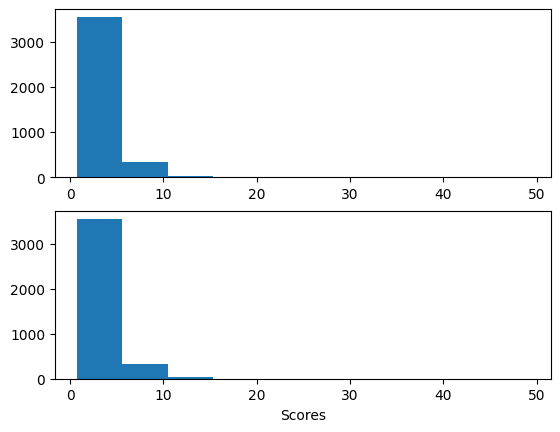

In [24]:
ax1 = plt.subplot(2, 1, 1)
plt.hist(train_scores)

ax2 = plt.subplot(2, 1, 2)
plt.hist(train_scores)
plt.xlabel('Scores')

plt.show()

In [25]:
clf.threshold_

5.167710590362548

## 5. PyOD: Variational Autoencoder

In [26]:
import pyod
from pyod.models.vae import VAE

In [32]:
clf_name = 'VAE'
clf = VAE(encoder_neuron_list = [2, 32, 64],
          decoder_neuron_list = [64, 32, 2],
          epoch_num=30, 
          batch_size=128)
clf.fit(train_df)

Training: 100%|██████████| 30/30 [00:05<00:00,  5.38it/s]


In [33]:
train_pred = clf.labels_  
train_scores = clf.decision_scores_ 

test_pred = clf.predict(test_df)  
test_scores = clf.decision_function(test_df) 

In [34]:
train_pred

array([0, 0, 0, ..., 0, 0, 0])

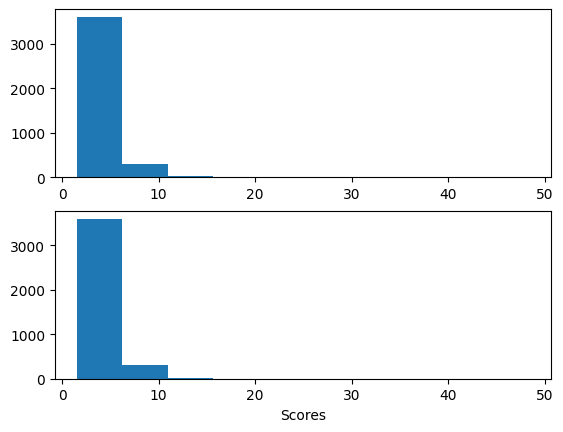

In [35]:
ax1 = plt.subplot(2, 1, 1)
plt.hist(train_scores)

ax2 = plt.subplot(2, 1, 2)
plt.hist(train_scores)
plt.xlabel('Scores')

plt.show()

In [36]:
clf.threshold_

5.164724731445311